In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
from fastai.vision.all import *

## Set up DataFrames

In [4]:
base_path = Path('src')

img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

In [5]:
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

Add the path to the image-file.

In [6]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

Different image files might contain the same image (have the same image_phas).

In [7]:
print(f'Unique images: {df_train.image_phash.nunique()} of {df_train.image.nunique()} unique image-files.')

Unique images: 28735 of 32412 unique image-files.


Drop duplicate image_phashs, since we wont "learn" anything from comparing the image to itself.

In [8]:
df_train.drop_duplicates(['image_phash'], inplace = True)

Only keep instances that belong to a label_group that contains more than one image_phash. This way it's possible to create a "same" and a "not same" instance for every image_phash.

In [9]:
df_groupby_label = df_train.groupby(['label_group'])['image_phash'].nunique().to_frame()

In [10]:
print(f'Number of labels, that contain only one image_phash: {(df_groupby_label.image_phash < 2).sum()}')

Number of labels, that contain only one image_phash: 1039


In [11]:
keep_labels = df_groupby_label[df_groupby_label.image_phash >= 2].index.tolist()
df_train = df_train[df_train['label_group'].isin(keep_labels)].reset_index(drop = True)

In [12]:
# Sanity check:
print(f"Number of labels, that contain only one image_phash: {(df_train.groupby(['label_group'])['image_phash'].nunique() < 2).sum()}")
print(f"Number of duplicate files: {df_train.duplicated(['image']).sum()}")

Number of labels, that contain only one image_phash: 0
Number of duplicate files: 0


We can now make shure to draw image-files with different phashes, when creating the Siamese dataset.

## Create smaller dataset for testing puposes

In [13]:
small_pct = 0.1

In [14]:
x = df_train['label_group'].unique()
y = np.random.choice(x, size = int(len(x)*small_pct), replace = False)
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [15]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_2985955659,src/train_images/002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTerry - Fit L,3415582503
1,train_999391364,src/train_images/00324695e37299a00b955674d984592b.jpg,a734d84d34702f37,Safi Dermasafe Night Moisturiser 50 gr,3624674138
2,train_1617041019,src/train_images/004811219262c545d74e427c5ea2d724.jpg,eae237c46618c799,Molina Kaftan / YADITA SPARKLE KAFTAN / KEANU DIAMOND KAFTAN / Talisha Kaftan,894203507
3,train_1449570166,src/train_images/004ede0e328d05780813f853857463f1.jpg,c1d43c3f1f949685,Citra Tone Up Pearly White Body Lotion 180 ml / 180ml,3578753118
4,train_1243594898,src/train_images/006860e5c85173a4949a924ddcb5127a.jpg,a317b5e8d621cae1,TRACK RACER THOMAS SUPER MOTORDROME I,1990957212


## Create Siamese TransformerLists

This part is very much copied from the fastai [tutorials](https://docs.fast.ai/tutorial.siamese.html). 

In [16]:
def open_image(fname, size=224):
    img = Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [17]:
def split_by_label(df):
    # L-list of unique labels
    labels = L(df.label_group.unique().tolist())
    # Randomly split labels
    split_labels = RandomSplitter(valid_pct=0.2)(labels)  # Returns 80/20 split of labels

    # Mask labels to receive train/val labels
    train_labels = labels[split_labels[0]]
    validation_labels = labels[split_labels[1]]

    # Add colum to mark file as a part of the training/validation set
    df['is_valid'] = df_train.label_group.isin(validation_labels)

    # Sanity check:
    assert((df.groupby(['label_group'])['is_valid'].nunique() > 1).sum() == 0)
    
    files = L(df['image'].tolist())
    train_idx = df[df['is_valid'] == False].index.tolist()
    validation_idx = df[df['is_valid'] == True].index.tolist()
    
    # Sanity check:
    assert(set(files[train_idx]) == set(df[df['is_valid'] == False]['image']))
    assert(set(files[validation_idx]) == set (df[df['is_valid'] == True]['image']))
    
    return files, train_labels, validation_labels, train_idx, validation_idx

In [18]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s:
            return i
    raise ValueError(f'File {f} is not presented in any split.')

In [19]:
def label_func(f):
    return df_train[df_train['image'] == f]['label_group'].values[0]

In [20]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [21]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
        
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f, 0))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split = 0):
            same = random.random() < 0.5

            cls = label_func(f)
            split = get_split(f)

            if not same:
                cls = random.choice([l for l in labels[split] if l != cls])

            return random.choice([f2 for f2 in self.splbl2files[split][cls] if f2 != f]),int(same)

In [22]:
@typedispatch
def show_batch(x:SiameseImage, 
               y, 
               samples, 
               ctxs=None, 
               max_n=6, 
               nrows=None, 
               ncols=2, 
               figsize=None, 
               **kwargs
              ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [23]:
def get_loaders(tls, size = 224, arc = None):
    
    bss = {112: 64, 224: 32, 480: 16}
    bs = bss[size]
    
    if arc and arc.__name__ == 'densenet121':
        bs = int(bs / 2.)
    
    return tls.dataloaders(after_item=[Resize(size), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs = bs
                     )

In [24]:
files, train_labels, validation_labels, train_split, val_split = split_by_label(df_train)
splits = (train_split, val_split)
labels = (train_labels,validation_labels)

In [25]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [26]:
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits = splits)

size = 112
dls = get_loaders(tls, size)

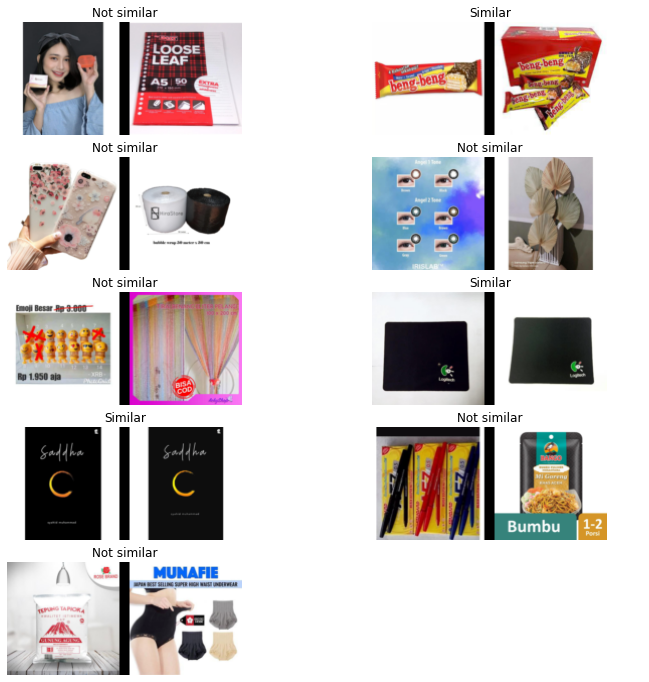

In [27]:
dls.show_batch()

In [28]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [29]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [30]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [31]:
def get_learner(dls, model, metrics = accuracy):
    return Learner(dls,
                model,
                #loss_func = loss_func,
                loss_func = CrossEntropyLossFlat(),
                splitter = siamese_splitter,
                metrics = metrics
               ).to_fp16()

In [81]:
encoder_nouts = {resnet34: 1024, xresnet34: 1024, xresnet50: 4096, densenet121: 2048}

if not small_pct:
    small_pct = 'full'

## Resnet34 from size 112 to 224

In [36]:
arc = resnet34
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)

head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.00010964782268274575)

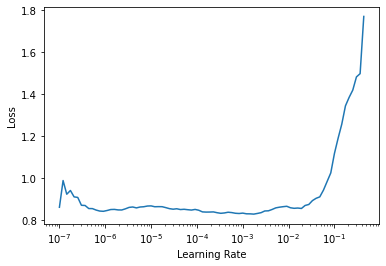

In [37]:
learn.freeze()
learn.lr_find()

In [38]:
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.833178,0.767629,0.511986,00:10
1,0.800184,0.725024,0.585616,00:09
2,0.740021,0.657190,0.642123,00:09
3,0.690913,0.622346,0.647260,00:09
4,0.642059,0.597014,0.666096,00:09
5,0.610179,0.586864,0.660959,00:09
6,0.583833,0.586972,0.659247,00:09


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=2.2908675418875646e-06)

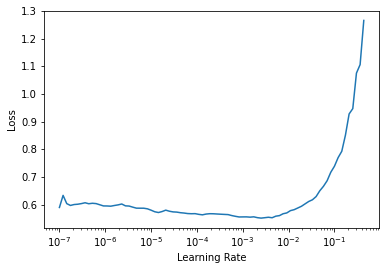

In [39]:
learn.unfreeze()
learn.lr_find()

In [41]:
learn.fit_one_cycle(5, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.568659,0.610992,0.657534,00:10
1,0.579246,0.598983,0.667808,00:10
2,0.575017,0.575353,0.690068,00:10
3,0.551847,0.563314,0.695205,00:10
4,0.531784,0.561927,0.688356,00:10


In [49]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

Path('models/shopee_0.1_resnet34_112.pth')

In [51]:
size_pre = 112
size = 224
dls = get_loaders(tls, size)
learner = get_learner(dls, model)
learn.load(f'shopee_{small_pct}_{arc.__name__}_{size_pre}');

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=1.3182567499825382e-06)

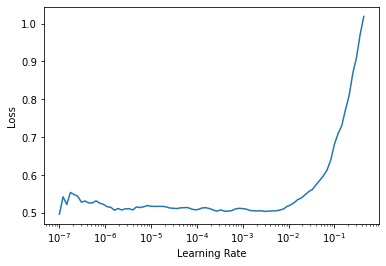

In [52]:
learn.freeze()
learn.lr_find()

In [53]:
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.497350,0.538628,0.705479,00:09
1,0.493248,0.542111,0.729452,00:09
2,0.496655,0.552673,0.720890,00:09
3,0.483629,0.534277,0.727740,00:09
4,0.453532,0.501157,0.744863,00:09
5,0.430108,0.481739,0.758562,00:09
6,0.413063,0.483331,0.760274,00:10


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

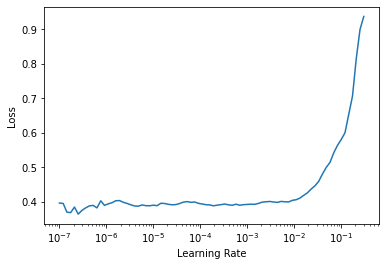

In [54]:
learn.unfreeze()
learn.lr_find()

In [55]:
learn.fit_one_cycle(4, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.390844,0.504621,0.750000,00:10
1,0.416502,0.494230,0.746575,00:10
2,0.409317,0.492277,0.765411,00:09
3,0.405287,0.488819,0.760274,00:10


In [56]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

Path('models/shopee_0.1_resnet34_224.pth')

## XResNet34 from size 112 to 224

In [64]:
arc = xresnet34
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)


head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=9.12010818865383e-07)

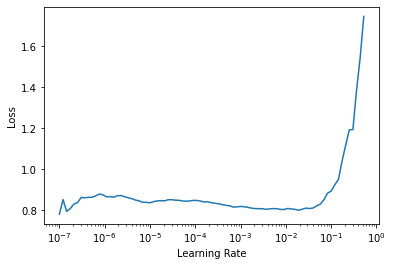

In [65]:
learn.freeze()
learn.lr_find()

In [66]:
learn.fit_one_cycle(7, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.787223,0.756533,0.559932,00:10
1,0.793396,1.143530,0.523973,00:10
2,0.793939,0.737885,0.640411,00:10
3,0.752711,0.702838,0.640411,00:10
4,0.697600,0.598070,0.702055,00:10
5,0.649511,0.576919,0.686644,00:10
6,0.602237,0.571436,0.698630,00:10


SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=7.585775847473997e-07)

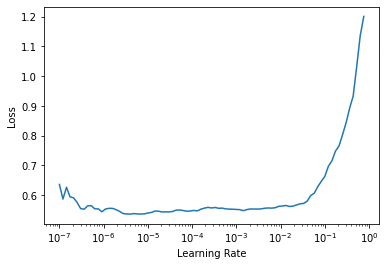

In [67]:
learn.unfreeze()
learn.lr_find()

In [68]:
learn.fit_one_cycle(5, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.537929,0.569799,0.686644,00:10
1,0.569583,0.561807,0.719178,00:10
2,0.556313,0.558804,0.717466,00:10
3,0.550147,0.558337,0.705479,00:10
4,0.545164,0.561720,0.698630,00:10


In [69]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

Path('models/shopee_0.1_xresnet34_112.pth')

In [70]:
size_pre = size
size = 224

dls = get_loaders(tls, size)
learner = get_learner(dls, model)
learn.load(f'shopee_{small_pct}_{arc.__name__}_{size_pre}');

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=5.754399353463668e-06)

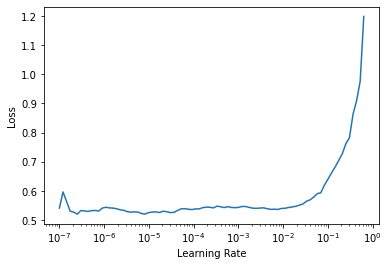

In [71]:
learn.freeze()
learn.lr_find()

In [72]:
learn.fit_one_cycle(7, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.533693,0.545141,0.710616,00:10
1,0.534091,0.559864,0.707192,00:10
2,0.535315,0.600087,0.683219,00:10
3,0.543617,0.539034,0.719178,00:11
4,0.526223,0.535236,0.736301,00:10
5,0.526056,0.536942,0.727740,00:10
6,0.505858,0.534501,0.727740,00:10


SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=8.31763736641733e-06)

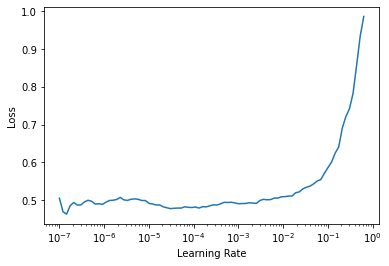

In [73]:
learn.unfreeze()
learn.lr_find()

In [76]:
learn.fit_one_cycle(5, slice(1e-6,1e-4,))

epoch,train_loss,valid_loss,accuracy,time
0,0.495539,0.534035,0.724315,00:10
1,0.497976,0.533547,0.719178,00:10
2,0.489686,0.534120,0.722603,00:10
3,0.497192,0.534630,0.726027,00:10
4,0.496531,0.531191,0.729452,00:10


In [77]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

Path('models/shopee_0.1_xresnet34_224.pth')

## XResNet50 size from 112 to 224

In [82]:
arc = xresnet50
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)


head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

In [83]:
learn.freeze()
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 5.92 GiB already allocated; 34.56 MiB free; 6.05 GiB reserved in total by PyTorch)

In [ ]:
learn.fit_one_cycle()

In [ ]:
learn.

In [ ]:
@typedispatch
def show_results(x:SiameseImage, 
                 y, 
                 samples, 
                 outs, 
                 ctxs=None, 
                 max_n=6, 
                 nrows=None, 
                 ncols=2, 
                 figsize=None, 
                 **kwargs                
                ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
        
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
        
    for i,ctx in enumerate(ctxs):
        title = f'Actual: {["Not similar","Similar"][int(x[2][i].item())]} \n Prediction: {["Not similar","Similar"][y[2][i].argmax().item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [ ]:
learn.show_results()

In [ ]:
preds = learn.get_preds()

In [ ]:
print(type(preds[1]))

In [ ]:
len(preds[1]), preds[1].sum()

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [ ]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

In [ ]:
res = learn.siampredict(siamtest)